# Image Classifier Build



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load and prepare nutrition lookup table
nutrition_df = pd.read_csv("/content/drive/MyDrive/CIS515 Project/Nutrition_db.csv")

# Clean and convert to lowercase lookup dict
nutrition_df = nutrition_df.dropna(subset=["food_name"])
nutrition_lookup = {
    str(row["food_name"]).strip().lower(): row.drop("food_name").to_dict()
    for _, row in nutrition_df.iterrows()
}

In [ ]:
!pip install -q tensorflow-datasets

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

# 📂 Step 2: Load and Preprocess Food-101 Dataset
def preprocess(image, label):
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Load dataset
(ds_train, ds_val), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    as_supervised=True,
    with_info=True
)

# Prepare batches
BATCH_SIZE = 32
train_ds = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.RWDUAS_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.RWDUAS_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# 🧠 Step 3: Build Model with Embedding + Softmax Head

# Load base MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Embedding layer
embedding_output = Dense(128, activation='relu', name='embedding_layer')(x)

# Classification head (temporary)
softmax_output = Dense(101, activation='softmax', name='softmax_head')(embedding_output)

# Full model
classification_model = Model(inputs=base_model.input, outputs=softmax_output)

# Unfreeze top 30 layers for fine-tuning
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Compile the model
classification_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# DON'T SPEND 4 HOURS FITTING THIS MODEL -- LOAD THE PRETRAINED MODEL BELOW

In [ ]:
# 🎯 Step 4: Train the Model on Food-101
EPOCHS = 5  # You can increase to 10–15 for better performance

history = classification_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1943s 814ms/step - accuracy: 0.0404 - loss: 4.5548 - val_accuracy: 0.2238 - val_loss: 3.4866
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 2259s 953ms/step - accuracy: 0.2519 - loss: 3.3739 - val_accuracy: 0.3940 - val_loss: 2.5528
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 2008s 847ms/step - accuracy: 0.3860 - loss: 2.6424 - val_accuracy: 0.4640 - val_loss: 2.1852
Epoch 4/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1977s 834ms/step - accuracy: 0.4472 - loss: 2.2994 - val_accuracy: 0.5032 - val_loss: 1.9848
Epoch 5/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1954s 824ms/step - accuracy: 0.4897 - loss: 2.0850 - val_accuracy: 0.5292 - val_loss: 1.8614


In [ ]:
# 💾 Step 5: Save the Embedding Model

# Strip off the softmax head
embedding_model = Model(
    inputs=classification_model.input,
    outputs=classification_model.get_layer("embedding_layer").output
)

# Save the model
embedding_model.save("food_embedding_model_finetuned.keras")
print("✅ Saved: food_embedding_model_finetuned.keras")

✅ Saved: food_embedding_model_finetuned.keras


In [ ]:
classification_model.save("food_classification_model_finetuned.keras")
print("✅ Saved: food_classification_model_finetuned.keras")

✅ Saved: food_classification_model_finetuned.keras


## Convert HEIC files to jpeg

In [ ]:
!pip install pillow-heif

import pillow_heif
from PIL import Image
import os
import glob

def convert_heic_to_jpg(heic_path, output_path=None):
    heif_file = pillow_heif.read_heif(heic_path)
    img = Image.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data,
        "raw",
        heif_file.mode,
        heif_file.stride,
    )
    if output_path is None:
        output_path = heic_path.replace('.heic', '.jpg')
    img.save(output_path, format='JPEG')
    return output_path

def convert_all_heic_in_folder(folder):
    import glob
    import os

    # Look recursively in all subfolders
    heic_files = glob.glob(os.path.join(folder, "**/*.heic"), recursive=True)

    if not heic_files:
        print("🚫 No HEIC files found.")

    for file in heic_files:
        try:
            convert_heic_to_jpg(file)
            print(f"✅ Converted: {file}")
        except Exception as e:
            print(f"❌ Failed to convert {file}: {e}")


In [ ]:
# Convert files in folder to jpeg files
cafeteria_data_path = "/content/drive/MyDrive/CIS515 Project/Backgrounds"
convert_all_heic_in_folder(cafeteria_data_path)

convert_all_heic_in_folder(cafeteria_data_path)

✅ Converted: /content/drive/MyDrive/CIS515 Project/Backgrounds/IMG_4767.heic
✅ Converted: /content/drive/MyDrive/CIS515 Project/Backgrounds/IMG_4730.heic
✅ Converted: /content/drive/MyDrive/CIS515 Project/Backgrounds/IMG_4722.heic
✅ Converted: /content/drive/MyDrive/CIS515 Project/Backgrounds/IMG_4764.heic
✅ Converted: /content/drive/MyDrive/CIS515 Project/Backgrounds/IMG_4604.heic
✅ Converted: /content/drive/MyDrive/CIS515 Project/Backgrounds/IMG_4688.heic
✅ Converted: /content/drive/MyDrive/CIS515 Project/Backgrounds/IMG_4641.heic
✅ Converted: /content/drive/MyDrive/CIS515 Project/Backgrounds/IMG_4691.heic
✅ Converted: /content/drive/MyDrive/CIS515 Project/Backgrounds/IMG_4671.heic
✅ Converted: /content/drive/MyDrive/CIS515 Project/Backgrounds/IMG_4746.heic
✅ Converted: /content/drive/MyDrive/CIS515 Project/Backgrounds/IMG_4781.heic
✅ Converted: /content/drive/MyDrive/CIS515 Project/Backgrounds/IMG_4779.heic
✅ Converted: /content/drive/MyDrive/CIS515 Project/Backgrounds/IMG_4797.heic

# LOAD CAF IMAGES AND TRAINED MODEL IN THIS SECTION

## Load Cafeteria Images for training

In [ ]:
# Update path to your cafeteria training images
cafeteria_data_path = "/content/drive/MyDrive/CIS515 Project/Food pics"

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

# Shared parameters for both splits
split_kwargs = {
    "image_size": (128, 128),
    "validation_split": 0.2,
    "seed": 42,
    "batch_size": 32,
    "label_mode": "int"
}

# Load both subsets (train + validation)
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

train_ds = image_dataset_from_directory(
    cafeteria_data_path,
    subset="training",
    **split_kwargs
)

val_ds = image_dataset_from_directory(
    cafeteria_data_path,
    subset="validation",
    **split_kwargs
)

# Capture class names (same for both)
class_names = train_ds.class_names
print("Class names:", class_names)

# Normalize image pixel values [0, 1]
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

Found 179 files belonging to 6 classes.
Using 144 files for training.
Found 179 files belonging to 6 classes.
Using 35 files for validation.
Class names: ['Backgrounds', 'CaesarSalad', 'FrenchFries', 'Hamburger', 'HotDog', 'Pizza']


## Load Embedding Model and Extract Embeddings

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

embedding_model = load_model("/content/drive/MyDrive/CIS515 Project/Final_Models/food_embedding_model_finetuned (1).keras")

# Extract embeddings from training data
X_train, y_train = [], []

for images, labels in train_ds:
    embs = embedding_model.predict(images)
    X_train.append(embs)
    y_train.append(labels.numpy())

X_train = np.vstack(X_train)
y_train = np.concatenate(y_train)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


## Validation Set

In [ ]:
X_val, y_val = [], []

for images, labels in val_ds:
    embs = embedding_model.predict(images)
    X_val.append(embs)
    y_val.append(labels.numpy())

X_val = np.vstack(X_val)
y_val = np.concatenate(y_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


## Train a Menu-Specific Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import joblib

# ✅ Convert numeric labels to class names
y_train_str = [class_names[i] for i in y_train]

# ✅ Encode string labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train_str)

# ✅ Train the logistic regression classifier
clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
clf.fit(X_train, y_train_encoded)

# ✅ Save the classifier and label encoder
joblib.dump(clf, "/content/drive/MyDrive/CIS515 Project/cafeteria_logistic_classifier.pkl")
joblib.dump(encoder, "/content/drive/MyDrive/CIS515 Project/cafeteria_label_encoder.pkl")

print("✅ Classifier and encoder saved!")

✅ Classifier and encoder saved!


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Evaluate Performance

In [ ]:
import joblib

encoder = joblib.load('/content/drive/MyDrive/CIS515 Project/Final_Models/cafeteria_label_encoder.pkl')
clf = joblib.load('/content/drive/MyDrive/CIS515 Project/Final_Models/clf_final.pkl')

In [ ]:
from sklearn.metrics import classification_report

# ✅ Predict class indices
y_pred_encoded = clf.predict(X_val)

# ✅ Convert both predictions and ground truth to readable class names
y_pred_str = encoder.inverse_transform(y_pred_encoded)
y_val_str = [class_names[i] for i in y_val]

# ✅ Print classification performance
print("📊 Classification Report:")
print(classification_report(y_val_str, y_pred_str, target_names=encoder.classes_))

📊 Classification Report:
              precision    recall  f1-score   support

 Backgrounds       1.00      1.00      1.00         4
 CaesarSalad       1.00      1.00      1.00         1
 FrenchFries       1.00      0.88      0.93         8
   Hamburger       1.00      1.00      1.00         6
      HotDog       0.88      1.00      0.93         7
       Pizza       1.00      1.00      1.00         9

    accuracy                           0.97        35
   macro avg       0.98      0.98      0.98        35
weighted avg       0.97      0.97      0.97        35



## Predict on an uploaded image

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_food_with_nutrition(img_path, embedding_model, clf, encoder, threshold=0.5):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_tensor = np.expand_dims(img_array, axis=0)

    # Get embedding + prediction
    embedding = embedding_model.predict(img_tensor)
    pred_class = clf.predict(embedding)[0]
    pred_prob = clf.predict_proba(embedding).max()
    label = encoder.inverse_transform([pred_class])[0]

    if pred_prob < threshold or label.lower() == "background":
        return {"message": "No food item detected with high confidence."}


    return {
        "predicted_item": label,
        "confidence": round(pred_prob, 3)
    }

In [ ]:
uploaded_filename = "/content/drive/MyDrive/CIS515 Project/New Food Pics/peter-secan-kKXBw9Exn30-unsplash.jpg"

result = predict_food_with_nutrition(uploaded_filename, embedding_model, clf, encoder)
print("🍽️ Prediction:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
🍽️ Prediction: {'predicted_item': np.str_('HotDog'), 'confidence': np.float64(0.999)}


## Above Prediction is Correct

## Augment 100 photos to ensure it still performs well

In [ ]:
import tensorflow as tf
import os
from PIL import Image

# Define augmentations
augmenter = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(0.2),
])

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import glob

input_dir = "/content/drive/MyDrive/CIS515 Project/Food pics"
output_dir = "/content/drive/MyDrive/CIS515 Project/Augmented_pics"
os.makedirs(output_dir, exist_ok=True)

for class_name in os.listdir(input_dir):
    input_class_path = os.path.join(input_dir, class_name)
    output_class_path = os.path.join(output_dir, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    image_paths = glob.glob(os.path.join(input_class_path, "*.jpg"))

    for i, img_path in enumerate(image_paths):
        if i >= 200: break  # limit to 100 total

        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img) / 255.0
        img_tensor = tf.expand_dims(img_array, 0)

        # Apply augmentation
        augmented_tensor = augmenter(img_tensor, training=True)
        augmented_img = tf.squeeze(augmented_tensor).numpy()
        augmented_img = (augmented_img * 255).astype(np.uint8)

        # Save as new image
        aug_pil = Image.fromarray(augmented_img)
        out_path = os.path.join(output_class_path, f"aug_{i}.jpg")
        aug_pil.save(out_path)

print("✅ Augmented test set created!")

✅ Augmented test set created!


## Load augmented set for evaluation

In [ ]:
eval_aug_ds = image_dataset_from_directory(
    output_dir,
    image_size=(128, 128),
    batch_size=32
)

class_names = eval_aug_ds.class_names
eval_aug_ds = eval_aug_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

Found 114 files belonging to 6 classes.


In [ ]:
X_val, y_val = [], []

for images, labels in eval_aug_ds:
    embs = embedding_model.predict(images)
    X_val.append(embs)
    y_val.append(labels.numpy())

X_val = np.vstack(X_val)
y_val = np.concatenate(y_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


In [ ]:
# ✅ Predict class indices
y_pred_encoded = clf.predict(X_val)

# ✅ Convert both predictions and ground truth to readable class names
y_pred_str = encoder.inverse_transform(y_pred_encoded)
y_val_str = [class_names[i] for i in y_val]

# ✅ Print classification performance
print("📊 Classification Report:")
print(classification_report(y_val_str, y_pred_str, target_names=encoder.classes_))

📊 Classification Report:
              precision    recall  f1-score   support

 Backgrounds       0.23      0.94      0.37        16
 CaesarSalad       0.67      0.15      0.25        13
 FrenchFries       0.75      0.35      0.48        17
   Hamburger       0.80      0.36      0.50        22
      HotDog       0.85      0.50      0.63        22
       Pizza       0.71      0.42      0.53        24

    accuracy                           0.46       114
   macro avg       0.67      0.45      0.46       114
weighted avg       0.69      0.46      0.48       114



In [ ]:
eval_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/cafeteria_eval",
    image_size=(128, 128),
    batch_size=32
)

class_names = eval_ds.class_names

# Preprocess
eval_ds = eval_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

In [ ]:
# Predict
X_test, y_test = [], []
for images, labels in eval_ds:
    embs = embedding_model.predict(images)
    X_test.append(embs)
    y_test.append(labels.numpy())

X_test = np.vstack(X_test)
y_test = np.concatenate(y_test)

# True labels as strings
y_true = [class_names[i] for i in y_test]

# Predicted labels
y_pred = encoder.inverse_transform(clf.predict(X_test))

NameError: name 'eval_ds' is not defined

## Set up YOLOv5 for Multi-Item Detection

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17410, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 17410 (delta 63), reused 22 (delta 22), pack-reused 17326 (from 3)
Receiving objects: 100% (17410/17410), 16.29 MiB | 15.02 MiB/s, done.
Resolving deltas: 100% (11928/11928), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 136.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s 

In [ ]:
import torch
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-4-25 Python-3.11.12 torch-2.6.0+cu124 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 409MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


## Detect and Classify Items from Multi-Food Image

In [ ]:
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

def detect_and_crop_regions(image_path, confidence_threshold=0.0):
    if image_path.lower().endswith(".heic"):
        image_path = convert_heic_to_jpg(image_path)

    results = yolo_model(image_path)
    img = Image.open(image_path).convert("RGB")
    crops = []

    for *box, conf, cls in results.xyxy[0]:  # xyxy format
        if conf < confidence_threshold:
            continue                         # skip low-confidence detections

        x1, y1, x2, y2 = map(int, box)
        crop = img.crop((x1, y1, x2, y2))
        crops.append((crop, (x1, y1, x2, y2)))

    return crops

def classify_cropped_foods(crops, embedding_model, clf, encoder, classification_threshold=0.0):
    results = []
    for i, (crop, box) in enumerate(crops):
        img_array = img_to_array(crop.resize((128, 128))) / 255.0
        img_tensor = np.expand_dims(img_array, axis=0)
        embedding = embedding_model.predict(img_tensor)

        pred_class = clf.predict(embedding)[0]
        pred_prob = clf.predict_proba(embedding).max()

        if pred_prob < classification_threshold:
            continue                         # Skip predictions that the classifier is not confident about

        label = encoder.inverse_transform([pred_class])[0]

        if label.lower() == 'Backgrounds':
            continue                         # Skip background class

        results.append({
            "region_id": i+1,
            "bbox": box,
            "food_name": label,
            "confidence": round(pred_prob, 3)
        })
    return results

## Run Prediction on a Tray Image

In [ ]:
# Run detection + classification
tray_path = "/content/drive/MyDrive/CIS515 Project/Multi/IMG_4771.jpg"
crops = detect_and_crop_regions(tray_path)
results = classify_cropped_foods(crops, embedding_model, clf, encoder)

# Display results
for res in results:
    print(f"Region {res['region_id']}: {res['food_name']} ({res['confidence']})")

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Region 1: Pizza (0.999)
Region 2: CaesarSalad (0.968)
Region 3: CaesarSalad (0.59)


In [ ]:
results

[]

## Visualize YOLOv5 Bounding Boxes

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
%matplotlib inline

def draw_predictions_with_click_filter(image_path, results, classifier_outputs=None):
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)

    # Use default font (safe for Colab)
    font = ImageFont.load_default()

    for i, (*box, conf, cls) in enumerate(results.xyxy[0]):
        x1, y1, x2, y2 = map(int, box)
        label = f"{conf:.2f}"

        if classifier_outputs and i < len(classifier_outputs):
            label = f"{classifier_outputs[i]['food_name']} ({classifier_outputs[i]['confidence']})"

        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((x1 + 4, y1 + 4), label, fill="white", font=font)

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Predicted Regions (YOLO + Classifier)")
    plt.show()


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


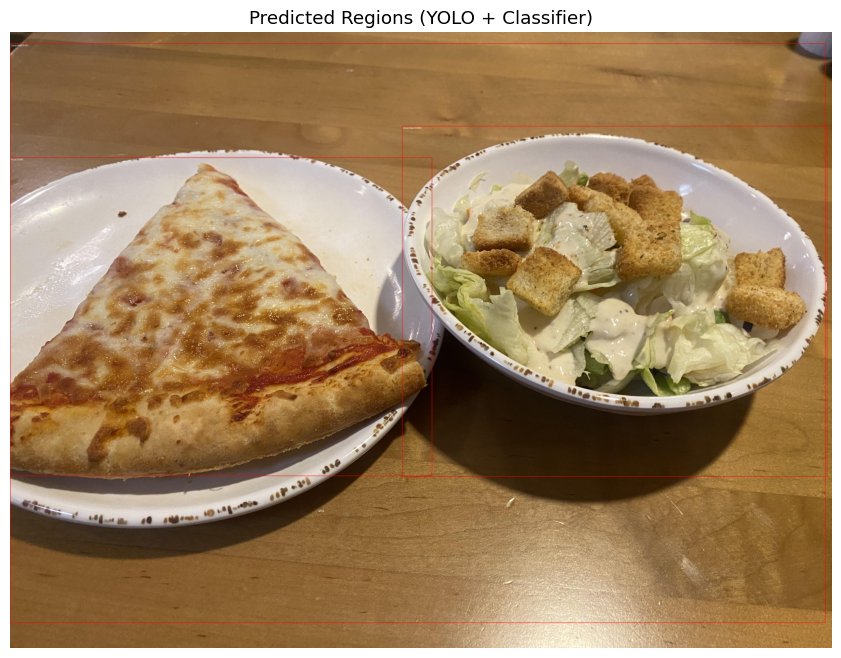

In [ ]:
image_path = "/content/drive/MyDrive/CIS515 Project/Multi/IMG_4771.jpg"
yolo_results = yolo_model(image_path)
crops = detect_and_crop_regions(image_path)
classified = classify_cropped_foods(crops, embedding_model, clf, encoder)

draw_predictions_with_click_filter(image_path, yolo_results, classified)
